In [ ]:
%load_ext autoreload
%autoreload 2

from typing import Dict, List
import json
from trace import TraceBank

In [ ]:
import requests
import time

lookback = 60*60*2

JAEGER_TRACES_ENDPOINT = f"http://localhost:6686/api/traces?limit=20000&lookback={lookback}s"
JAEGER_TRACES_SERVICE_PARAM = "&service="
JAEGER_TRACES_OPERATION_PARAM = "&operation="
JAEGER_TRACES_STARTTIME = "&start="
JAEGER_TRACES_ENDTIME = "&end="

def get_traces(service : str, operation : str):
    """
    Returns list of all traces for a service
    """
    url = JAEGER_TRACES_ENDPOINT \
        + JAEGER_TRACES_SERVICE_PARAM + service \
        + JAEGER_TRACES_OPERATION_PARAM + operation \
        + JAEGER_TRACES_STARTTIME + str(int((time.time() - lookback)*1000000)) \
        + JAEGER_TRACES_ENDTIME + str(int(time.time()*1000000))
    print(url)
    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        raise err

    response = json.loads(response.text)
    traces = response["data"]
    return TraceBank(traces)


In [ ]:
run_traces = get_traces("nexus-writer", "Run")
frame_traces = get_traces("digitiser-aggregator", "Frame")
event_formation_traces = get_traces("trace-to-events", "Trace Source Message")
simulator_traces = get_traces("simulator", "Trace")

In [ ]:
simulator_traces.find_parents_from_traces(simulator_traces)
event_formation_traces.find_parents_from_traces(event_formation_traces)
event_formation_traces.find_parents_from_traces(simulator_traces)
frame_traces.find_parents_from_traces(frame_traces)
run_traces.find_parents_from_traces(run_traces)

run_traces.find_heroes(frame_traces)
frame_traces.find_heroes(event_formation_traces)

In [46]:
from model import Run

run_list = list(r.get_span_subset("Run").values())
runs = {k: Run(run_list[0]) for (k,r) in run_traces.traces.items()}

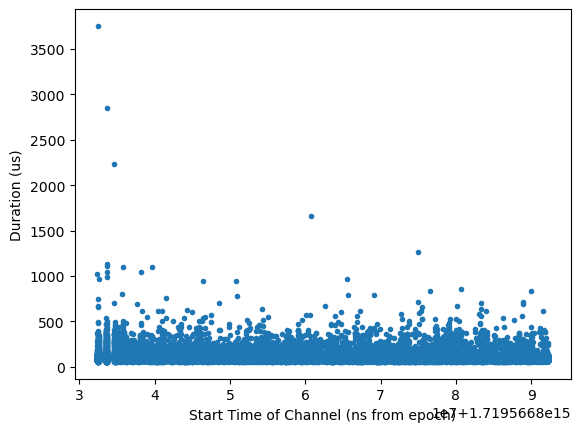

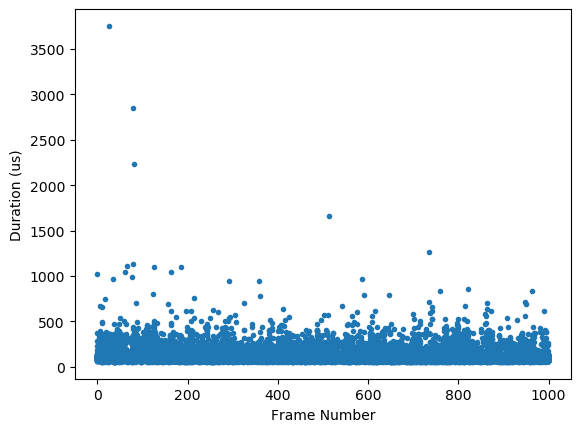

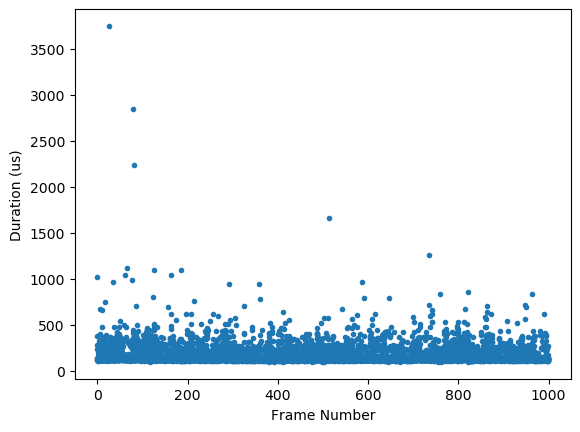

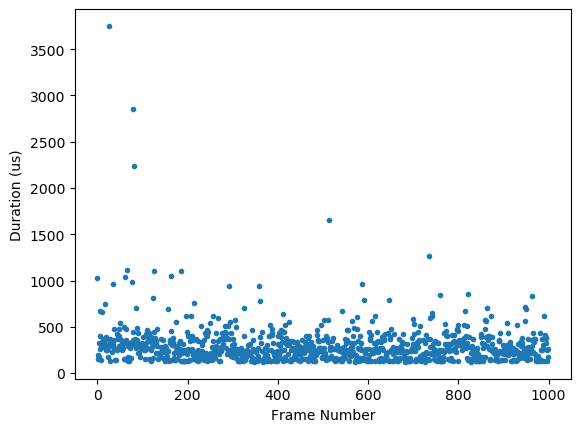

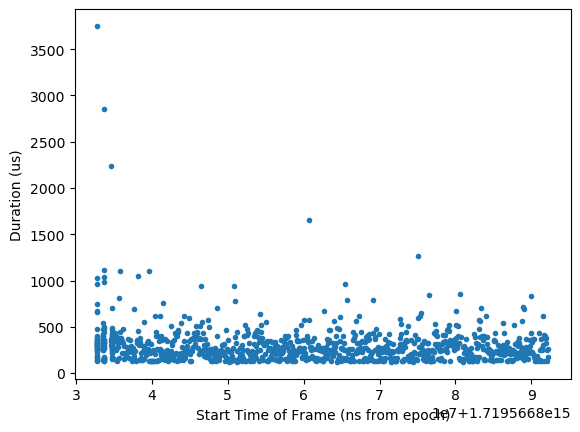

In [47]:
#print(list(runs.values())[0])
list(runs.values())[0].plot()